In [ ]:
# Code to load data from google drive

from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


58.07893401393003
(581, 3)
Clothoid_from_3,-3,-0.79_to_0,4,0.78_0.1


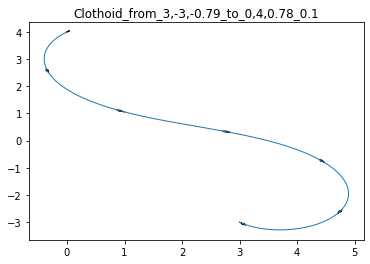

In [ ]:
import numpy as np
from scipy.integrate import odeint
from math import pi, floor
import matplotlib.pylab as plt
from math import atan2

#############################################################################################
########################## BUILD THE CLOTHOID - FUNCTION DEFINITION	#########################
#############################################################################################

def clothoid_ode_rhs(state, s, kappa0, kappa1, alpha):
    x, y, theta = state[0], state[1], state[2]
    return np.array([alpha*np.cos(theta), alpha*np.sin(theta), kappa0 + kappa1*s])

def eval_clothoid(x0,y0,theta0, kappa0, kappa1, s, alpha):
    return odeint(clothoid_ode_rhs, np.array([x0,y0,theta0]), s, (kappa0, kappa1, alpha))

def generalized_fresnel_fct(state,t,n,k,dk,theta0,alpha):
	return np.array([alpha*t**n*np.cos(theta0+k*t+dk*t**2/2),alpha*t**n*np.sin(theta0+k*t+dk*t**2/2)])

def int_generalized_fresnel_fct(n,k,dk,theta0,alpha):
	sol = [[],[]]
	t = [0,1]
	for i in range (0,n):
		sol_i = odeint(generalized_fresnel_fct, np.array([0,0]), t, (i, k, dk, theta0, alpha))
		sol[0].append(sol_i[1,0])
		sol[1].append(sol_i[1,1])
	return sol

def normalizeAngle(angle):
	new_angle = angle
	while new_angle > pi:
		new_angle -= 2*pi
	while new_angle < -pi:
		new_angle += 2*pi
	return new_angle

def build_clothoid_param(x0,y0,theta0,xf,yf,thetaf,alpha):
	dx = xf-x0
	dy = yf-y0
	R = np.sqrt(dx**2+dy**2)
	phi = atan2(dy,dx)
	phi0 =normalizeAngle(theta0-phi)
	phif = normalizeAngle(thetaf-phi)
	dphi = phif-phi0

	A_guess = guessA(phi0,phif)

	epsilon = 1e-12

	A = findA(A_guess,dphi,phi0,epsilon,alpha)

	sol = int_generalized_fresnel_fct(1,dphi-A,2*A,phi0,alpha)
	h = sol[0][0]
	L = R/h

	if L > 0:
		k = (dphi-A)/L
		dk = 2*A/L**2
		return (k,dk,L)
	else :
		print ("error: negative length")
		return(0,0,0)

def guessA(phi0,phif):
	coef = [2.989696028701907,0.716228953608281,-0.458969738821509,
	-0.502821153340377,0.261062141752652,-0.045854475238709]
	X  = phi0/pi
	Y  = phif/pi
	xy = X*Y
	A  = (phi0+phif) * ( coef[0] + xy * ( coef[1] + xy * coef[2] )+
		(coef[3] + xy * coef[4]) * (X**2+Y**2) + coef[5] * (X**4+Y**4))
	return A

def findA(A_guess, dphi, phi0, epsilon, alpha):
	A = A_guess
	k = 1
	n = 0
	while abs(k) > epsilon and n < 100:
		a = dphi-A
		b = 2*A
		c = phi0
		sol = int_generalized_fresnel_fct(3,a,b,c,alpha)
		intS = sol[1]
		intC = sol[0]
		k = intS[0]
		dk = intC[2]-intC[1]
		A  = A - k/dk
		n += 1
	if abs(k) > epsilon*10:
		print("Newton iteration fails, k = ",k)
		return 0
	else:
		return A

def plotClothoid(clothoid, title):
	x, y, theta = clothoid[:,0], clothoid[:,1], clothoid[:,2]
	plt.plot(x, y, lw=1)
	plt.title(title)

	arrow_len = 0.08
	count = 0
	for i in range (0,len(x)):
		if count%100 == 0:
			c, s = np.cos(theta[i]), np.sin(theta[i])
			plt.arrow(x[i], y[i], c * arrow_len, s * arrow_len, head_width=.05)
		count += 1
	plt.arrow(x[-1], y[-1], np.cos(theta[-1]) * arrow_len, np.sin(theta[-1]) * arrow_len)


def writeClothoid(x0,y0,theta0,xf,yf,thetaf,step,alpha):
	theta0, thetaf = floor(theta0*100)/100, floor(thetaf*100)/100
	k,dk,L = build_clothoid_param(x0,y0,theta0,xf,yf,thetaf,alpha)
	print(L)
	sol = eval_clothoid(x0, y0, theta0, k, dk, np.arange(0,L,step), alpha)
	print(sol.shape)
	title = "Clothoid_from_"+str(x0)+","+str(y0)+","+str(theta0) \
	+"_to_"+str(xf)+","+str(yf)+","+str(thetaf)+"_"+str(step)
	print(title)
	plotClothoid(sol,title)
	#plt.show()
	path = "/content/drive/MyDrive/VLC/other files/path16.dat"
	np.savetxt(path,sol)
	vsol = np.zeros((len(sol[:,0])-1,3))
	for i in range (0,len(sol[:,0])-1):
		vsol[i][0]=(sol[:,0][i+1]-sol[:,0][i])/step
		vsol[i][1]=(sol[:,1][i+1]-sol[:,1][i])/step
		vsol[i][2]=(sol[:,2][i+1]-sol[:,2][i])/step
	#vpath = "/content/drive/MyDrive/VLC/other files/path01.dat"
	#np.savetxt(vpath,vsol)

###############################################################################
################################## MAIN #######################################
###############################################################################

#writeClothoid(-2, -4.5, pi, 4.5, 4, pi/2, 0.05, 0.2) # pi/2, step=0.01
#writeClothoid(-2, -4.5, pi/2, 4.5, 4, pi/2, 0.05, 0.2) # pi/2, step=0.01
#writeClothoid(-3, 3, -pi, 4, -4.5, -pi/2, 0.05, 0.2) # pi/2, step=0.01
#writeClothoid(-3, 3, pi/2, 4, -3, pi/2, 0.05, 0.2) # pi/2, step=0.01

#writeClothoid(4, -4.5, pi, -4.5, 4, pi/2, 0.05, 0.2) # pi/2, step=0.01
#writeClothoid(4, -4.5, pi/2, -4.5, 4, pi/2, 0.05, 0.2) # pi/2, step=0.01
#writeClothoid(4.5, 3, -pi/2, -4, -4.5, -pi/2, 0.05, 0.2) # pi/2, step=0.01
#writeClothoid(4.5, 3, pi/2, -4, -3, pi/2, 0.05, 0.2) # pi/2, step=0.01

#writeClothoid(-3, -4, pi/4, 3, 4.5, 3*pi/4, 0.1, 0.2) # pi/2, step=0.01
#writeClothoid(-3, 4, pi/4, 3, -4.5, pi/4, 0.1, 0.2) # pi/2, step=0.01
#writeClothoid(-2, 3, pi/2, 2.5, -4, pi/4, 0.1, 0.2) # pi/2, step=0.01
#writeClothoid(-4, -2.5, pi/2, 4.5, 4, pi/4, 0.1, 0.2) # pi/2, step=0.01
#writeClothoid(-4.5, -3, -pi/2, 4, 2.5, -pi/4, 0.1, 0.2) # pi/2, step=0.01
#writeClothoid(0, 4, -pi/4, 0, -4, 3*pi/4, 0.1, 0.2) # pi/2, step=0.01
#writeClothoid(4, 1, -pi/4, -4, -1, 3*pi/4, 0.1, 0.2) # pi/2, step=0.01
#writeClothoid(3, -3, -pi/4, 0, 4, pi/4, 0.1, 0.2) # pi/2, step=0.01

plt.show()



In [ ]:
import numpy as np
import matplotlib.pylab as plt
from math import pi,floor,atan2,atan
from scipy.interpolate import splprep, splev

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#########################################################################################
################################## FCT DEFINITION #######################################
#########################################################################################

def readModel(path,time):
	length = 500
	curv = np.transpose(np.loadtxt(path))
	x = curv[0]
	y = curv[1]
	theta = curv[2]
	time_model = np.linspace(0,length,len(x))

	okay = np.where(np.abs(np.diff(x)) + np.abs(np.diff(y)) > 0)
	x = x[okay]
	y = y[okay]
	tck, u = splprep([x, y], s=0)
	unew = np.linspace(0,1,length)
	data = splev(unew, tck)
	x,y = data[0],data[1]

	theta = np.interp(time,time_model,theta)

	delta_y = np.diff(y)
	delta_x = np.diff(x)
	th_local = []
	for i in range (len(delta_x)):
		phi = atan2(delta_y[i],delta_x[i])
		th_local.append(phi-theta[i])
	return (x,y,th_local,theta)

def distanceBetweenCurvs(x_real,x_sim,y_real,y_sim):
	distance = 0
	length = len(x_real)

	distance_fin = np.sqrt((x_sim[-1]-x_real[-1])**2+(y_sim[-1]-y_real[-1])**2)

	okay = np.where(np.abs(np.diff(x_real)) + np.abs(np.diff(y_real)) > 0)
	x_real = x_real[okay]
	y_real = y_real[okay]
	tck, u = splprep([x_real, y_real], s=0)
	unew = np.linspace(0,1,length)
	data = splev(unew, tck)
	x_real,y_real = data[0],data[1]

	for i in range (length):
		distance += np.sqrt((x_sim[i]-x_real[i])**2+(y_sim[i]-y_real[i])**2)
	# 	if i%25 == 0:
	# 		# print(i, "sim",x_sim[i],y_sim[i])
	# 		# print(np.sqrt((x_sim[i]-x_real[i])**2+(y_sim[i]-y_real[i])**2))
	# 		plt.plot([x_sim[i],x_real[i]], [y_sim[i],y_real[i]], color = 'black', linewidth = 0.5)
	# # 	# print(distance)
	# plt.plot(x_sim,y_sim,color='blue')
	# plt.plot(x_real,y_real,color='red')
	# plt.plot(x_sim, y_sim,color='cyan',linestyle=':', marker='o')
	# plt.plot(x_real, y_real,color='orange',linestyle=':', marker='o')
	# plt.show()
	# # print("dist_i :",distance/500)
	return distance/length,distance_fin

def normalizeAngle(angle):
	new_angle = angle
	while new_angle > pi:
		new_angle -= 2*pi
	while new_angle < -pi:
		new_angle += 2*pi
	return new_angle

def angularDistanceBetweenCurvs(th_real,th_sim):
	distance = 0
	distance_fin = abs(pi/2-normalizeAngle(th_sim[-1]))


	for i in range (len(th_real)-1):
		distance += abs(normalizeAngle(th_real[i])-normalizeAngle(th_sim[i]))
	# 	print(abs(th_real[i]-th_sim[i]))
	# 	plt.plot([time[i],time[i]], [th_real[i],th_sim[i]], color = 'black', linewidth = 0.5)

	# plt.plot(time,th_real,linestyle=':', marker='o')
	# plt.plot(time,th_sim,linestyle=':', marker='o')
	# print("--------",distance/len(th_real))
	# plt.show()

	return distance/len(th_sim),distance_fin

#########################################################################################
################################## MAIN #################################################
#########################################################################################

direction_list = ['N','E','S','O']
position_list = ['1500','4000','-0615','0615','1515','4015','-0640','0640','1540','4040']
path_human_list = []
for pos in position_list:
	for direction in direction_list:
		name_file = direction+pos+".dat"
		path_human_list.append('/content/drive/MyDrive/VLC/Human/'+name_file)

init_pos_list = []
start_and_end = np.loadtxt("/content/drive/MyDrive/VLC/Human/StartAndEnd.dat")
for i in range(len(start_and_end)):
	init_pos_list.append([floor(start_and_end[i][0]*1000)/1000,floor(start_and_end[i][1]*1000)/1000])
fin_pos = [0,0,1.57]
orientation_list = [1.57,0.0,-1.58,3.14]
path_clothoid_list,path_ddp_list = [],[]
i = 0
for pos in init_pos_list:
	# name_file = 'Clothoid_from_'+str(pos[0])+','+str(pos[1])+','+str(orientation_list[i%4])+\
	# '_to_'+str(fin_pos[0])+','+str(fin_pos[1])+','+str(fin_pos[2])+'_0.001_pos.dat'
	# path_clothoid_list.append('data/Clothoid/'+name_file)
	name_file = 'DdpResult_from_'+str(pos[0])+','+str(pos[1])+','+str(orientation_list[i%4])+\
	'_to_'+str(fin_pos[0])+','+str(fin_pos[1])+','+str(fin_pos[2])+'_pos.dat'
	path_ddp_list.append('data/DdpResult/'+name_file)
	i += 1

init_pos_list = []
start_and_end = np.loadtxt("/content/drive/MyDrive/VLC/Human/StartAndEnd.dat")
for i in range(len(start_and_end)):
	init_pos_list.append([floor(start_and_end[i][0]*1000)/1000,floor(start_and_end[i][1]*1000)/1000])
fin_pos = [0,0,1.57]
orientation_list = [1.57,0.0,-1.58,3.14]
path_clothoid_list= []
i = 0
for pos in init_pos_list:
	name_file = 'DdpResult_from_'+str(pos[0])+','+str(pos[1])+','+str(orientation_list[i%4])+\
	'_to_'+str(fin_pos[0])+','+str(fin_pos[1])+','+str(fin_pos[2])+'_pos.dat'
	path_clothoid_list.append('data/DdpResult/DataIROS/'+name_file)
	i += 1

time = np.arange(0,500,1)

fig = plt.figure()
count = 1
dist_clothoid_list, dist_ddp_list,angular_dist_clothoid_list, angular_dist_ddp_list = [],[],[],[]
dist_fin_ddp_list , angular_dist_fin_ddp_list = [],[]
dist_subjects_ddp_list , angular_dist_subjects_ddp_list = [],[]

for i in range (len(path_human_list)):
	title = path_human_list[i][11:17]
	#print(title)
	#ax = plt.subplot(1,4,count)

	ax = plt.subplot(4,10,count)

	#if title == 'E1540.' or title == 'N-0615' or title == 'S4015.' or title == 'O0640.':

	print(title,i,count)

	human_data = np.loadtxt(path_human_list[i])
	# (x_clothoid,y_clothoid,theta_clothoid) = readModel(path_clothoid_list[i],time)
	(x_ddp,y_ddp,theta_local_ddp,theta_global_ddp) = readModel(path_ddp_list[i],time)

	plt.plot(x_ddp,y_ddp,label='OC',color='red',linewidth=1.5)

	plt.plot(human_data[6],human_data[7],label='Subjects',color='lime',linewidth=0.75,alpha = 0.4)
	plt.plot(human_data[12],human_data[13],color='lime',linewidth=0.75,alpha = 0.4)
	plt.plot(human_data[18],human_data[19],color='lime',linewidth=0.75,alpha = 0.4)
	plt.plot(human_data[24],human_data[25],color='lime',linewidth=0.75,alpha = 0.4)
	plt.plot(human_data[30],human_data[31],color='lime',linewidth=0.75,alpha = 0.4)
	plt.plot(human_data[36],human_data[37],color='lime',linewidth=0.75,alpha = 0.4)
	plt.plot(human_data[42],human_data[43],color='lime',linewidth=0.75,alpha = 0.4)
	plt.plot(human_data[48],human_data[49],color='lime',linewidth=0.75,alpha = 0.4)
	plt.plot(human_data[54],human_data[55],color='lime',linewidth=0.75,alpha = 0.4)
	plt.plot(human_data[60],human_data[61],color='lime',linewidth=0.75,alpha = 0.4)
	plt.plot(human_data[0],human_data[1],label='Human average',color='green',linewidth=1.5)

	if np.sum(human_data[5]) != 0:
		arrow_len = 0.2
		for i in range (len(human_data[0])):
			if i%50 == 0:
				plt.arrow(human_data[0][i], human_data[1][i], np.cos(human_data[5][i])*arrow_len, np.sin(human_data[5][i])*arrow_len, head_width=.03,color='green')
				plt.arrow(x_ddp[i], y_ddp[i], np.cos(theta_global_ddp[i])*arrow_len, np.sin(theta_global_ddp[i])*arrow_len, head_width=.03,color='red')
	plt.arrow(x_ddp[-1], y_ddp[-1], np.cos(theta_global_ddp[-1])*arrow_len, np.sin(theta_global_ddp[-1])*arrow_len, head_width=.03,color='red')

	# plt.plot(time,v,color='orange')
	# plt.plot([time[end]]*len(time),np.linspace(0,6,len(time)),color ='black')
	# plt.plot([time[begin]]*len(time),np.linspace(0,6,len(time)),color ='black')
	# plt.plot(time,human_data[5],linestyle=':',color ='black')
	# plt.plot(time,theta_clothoid,color='red')
	# plt.plot(time,theta_ddp,color='blue')
	# plt.plot(time,theta_trunc,color='green')
	# plt.plot(time,human_data[11],color='lime',linewidth=0.75,alpha = 0.4)
	# plt.plot(time,human_data[17],color='lime',linewidth=0.75,alpha = 0.4)
	# plt.plot(time,human_data[23],color='lime',linewidth=0.75,alpha = 0.4)
	# plt.plot(time,human_data[29],color='lime',linewidth=0.75,alpha = 0.4)
	# plt.plot(time,human_data[35],color='lime',linewidth=0.75,alpha = 0.4)
	# plt.plot(time,human_data[41],color='lime',linewidth=0.75,alpha = 0.4)
	# plt.plot(time,human_data[47],color='lime',linewidth=0.75,alpha = 0.4)
	# plt.plot(time,human_data[53],color='lime',linewidth=0.75,alpha = 0.4)
	# plt.plot(time,human_data[59],color='lime',linewidth=0.75,alpha = 0.4)
	# plt.plot(time,human_data[65],color='lime',linewidth=0.75,alpha = 0.4)

	# dist_clotho = distanceBetweenCurvs(human_data[0],x_clothoid,human_data[1],y_clothoid)
	dist_ddp,dist_fin_ddp = distanceBetweenCurvs(human_data[0],x_ddp,human_data[1],y_ddp)

	# dist_clothoid_list.append(dist_clotho)
	dist_ddp_list.append(dist_ddp)
	dist_fin_ddp_list.append(dist_fin_ddp)

	for i in range (10):
		dist_subjects_ddp_list.append(distanceBetweenCurvs(human_data[6+i*6],x_ddp,human_data[7+i*6],y_ddp)[0])

	if np.sum(human_data[5]) != 0:
		print("yes")
		# angular_dist_clotho = angularDistanceBetweenCurvs(human_data[5],theta_clothoid)
		angular_dist_ddp,angular_dist_fin_ddp = angularDistanceBetweenCurvs(human_data[4],theta_local_ddp)
	else:
		# angular_dist_clotho = 0
		angular_dist_ddp,angular_dist_fin_ddp = 0,0
		print("no",title)

	# angular_dist_clothoid_list.append(angular_dist_clotho)
	angular_dist_ddp_list.append(angular_dist_ddp)
	angular_dist_fin_ddp_list.append(angular_dist_fin_ddp)

	#print(i,path_human_list[i][62:68],dist_clotho,dist_ddp)
	# plt.legend(fontsize = 'xx-large')
	# plt.title(title)
	plt.title("d_xy = " + str(floor(dist_ddp*10000)/10000) + " & d_eta = "+str(floor(angular_dist_ddp*10000)/10000), fontsize=18)

	# plt.title('clotho :'+str(floor(angular_dist_clotho*100)/100) + \
	# ' VS ddp :'+str(floor(angular_dist_ddp*100)/100))
	# plt.title('Clothoid-Human d_xy='+str(floor(dist_clotho*100)/100) + \
	# ' & d_th='+str(floor(angular_dist_clotho*100)/100)+ \
	# ', OC-Human d_xy='+str(floor(dist_ddp*100)/100)+ \
	# ' & d_th='+str(floor(angular_dist_ddp*100)/100))
	# ax.set_xticklabels([])
	# ax.set_yticklabels([])
	plt.ylabel("y (m)")
	plt.xlabel("x (m)")
	#if count < 4:
	count += 1
plt.show()

# path = "data/dist_clotho.dat"
# np.savetxt(path,dist_clothoid_list)

path = "data/dist_ddp.dat"
np.savetxt(path,dist_ddp_list)

path = "data/dist_fin_ddp.dat"
np.savetxt(path,dist_fin_ddp_list)

# path = "data/angular_dist_clotho.dat"
# np.savetxt(path,angular_dist_clothoid_list)

path = "data/angular_dist_ddp.dat"
np.savetxt(path,angular_dist_ddp_list)

path = "data/angular_dist_fin_ddp.dat"
np.savetxt(path,angular_dist_fin_ddp_list)

path = "data/dist_subjects_ddp.dat"
np.savetxt(path,dist_subjects_ddp_list)

OSError: ignored

In [ ]:
!pip install pinocchio

In [ ]:
!pip install pinocchio.rpy

ERROR: Could not find a version that satisfies the requirement pinocchio.rpy (from versions: none)
ERROR: No matching distribution found for pinocchio.rpy


In [ ]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from math import cos,sin
import pinocchio
from pinocchio.rpy import rpyToMatrix
from mpl_toolkits.mplot3d import Axes3D

data = np.transpose(np.loadtxt("data/nmpc_traj_offline.csv"))

# # time_interp = np.linspace(0,100, len(traj[0]))

# # plt.plot(time_interp, traj[0])
# # plt.plot(time_interp, traj[3])
# # plt.plot(time_com, com[0])
# # plt.plot(time_com, com[1])

# # plt.show()

# # plt.plot(time_interp, traj[14])
# # plt.plot(time_foot, footL[2])

# # plt.show()

com_file = open("data/com.dat", "w")
am_file = open("data/am.dat", "w")
phase_file = open("data/phases.dat", "w")
footR_file = open("data/rightFoot.dat", "w")
footL_file = open("data/leftFoot.dat", "w")

for i in range (len(data[0])):
	com_file.write(str(data[0][i]) + "  " + str(data[3][i]) + "  0.892675352  " +\
		str(data[1][i]) + "  " + str(data[4][i])+ "  0.0  " +\
		str(data[2][i]) + "  " + str(data[5][i])+ "  0.0\n")

	am_file.write(str(data[6][i]) + "  " + str(data[7][i])+ "  " + str(data[8][i]) + "\n")

	rotR = rpyToMatrix(0,0,data[15][i])

	footR_file.write(str(data[12][i]) + "  " + str(data[13][i])+ "  " +\
		str(data[14][i]) + "  " + str(rotR[0][0]) + "  " +\
		str(rotR[0][1]) + "  " + str(rotR[0][2]) + "  " + str(rotR[1][0]) +\
		"  " + str(rotR[1][1]) + "  " + str(rotR[1][2])+ "  " +\
		str(rotR[2][0]) + "  " + str(rotR[2][1])+ "  " + str(rotR[2][2])+"\n")

	rotL = rpyToMatrix(0,0,data[19][i])

	footL_file.write(str(data[16][i]) + "  " + str(data[17][i])+ "  " +\
		str(data[18][i]) + "  " + str(rotL[0][0]) + "  " +\
		str(rotL[0][1]) + "  " + str(rotL[0][2]) + "  " + str(rotL[1][0]) +\
		"  " + str(rotL[1][1]) + "  " + str(rotL[1][2])+ "  " +\
		str(rotL[2][0]) + "  " + str(rotL[2][1])+ "  " + str(rotL[2][2])+"\n")

	if data[14][i] == 0.105 and data[18][i] == 0.105: # DS Phase
		# print(0)
		phase_file.write("0\n")
	elif data[14][i] != 0.105: # SS Phase : Left = Support foot
		# print(1)
		phase_file.write("1\n")
	else :  # SS Phase : Right = Support foot
		# print(-1)
		phase_file.write("-1\n")

com_file.close()
am_file.close()
phase_file.close()
footR_file.close()
footL_file.close()

com = np.transpose(np.loadtxt("data/com.dat"))
footR = np.transpose(np.loadtxt("data/rightFoot.dat"))
footL = np.transpose(np.loadtxt("data/leftFoot.dat"))
phase = np.transpose(np.loadtxt("data/phases.dat"))
am = np.transpose(np.loadtxt("data/am.dat"))

plt.plot(com[0],com[1],color = 'blue',label='CoM')
plt.plot(footL[0],footL[1],color = 'green',label='Left Foot')
plt.plot(footR[0],footR[1],color = 'red',label='Right Foot')
legend = plt.legend()

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(com[0],com[1],com[2],color = 'blue',label='CoM')
ax.plot3D(footL[0],footL[1],footL[2],color = 'green',label='Left Foot')
ax.plot3D(footR[0],footR[1],footR[2],color = 'red',label='Right Foot')
legend = plt.legend()

plt.show()

# time_com = np.linspace(0,100,len(com[0]))
# time_foot = np.linspace(0,100,len(footR[0]))

# plt.plot(time_foot,footR[2])
# plt.plot(time_foot,footL[2])
# plt.plot(time_foot,phase)
# plt.show()
# plt.plot(time_foot,footL[0])
# plt.plot(time_foot,footR[0])
# plt.plot(time_foot,footL[1])
# plt.plot(time_foot,footR[1])
# plt.show()
# plt.plot(time_foot,np.arccos(footR[3]))
# plt.plot(time_foot,np.arccos(footL[3]))
# plt.show()

# time_reduced = np.arange(0,len(footR[0]),100)
# arrow_len = 0.1

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot3D(footL[0],footL[1],footL[2],color = 'green',label='Left Foot')
# ax.plot3D(footR[0],footR[1],footR[2],color = 'red',label='Right Foot')
# legend = plt.legend()

# ax.quiver(np.array(footR[0])[time_reduced],np.array(footR[1])[time_reduced],\
# 	np.array(footR[2])[time_reduced],np.array(footR[3])[time_reduced],\
# 	np.array(footR[6])[time_reduced],0, length=arrow_len, lw = 2)
# ax.quiver(np.array(footL[0])[time_reduced],np.array(footL[1])[time_reduced],\
# 	np.array(footL[2])[time_reduced],np.array(footL[3])[time_reduced],\
# 	np.array(footL[6])[time_reduced],0, length=arrow_len, lw = 2)

# ax.quiver(np.array(com[0])[time_reduced],np.array(com[1])[time_reduced],\
# 	np.array(com[2])[time_reduced],np.array(np.cos(am[0]))[time_reduced],\
# 	np.array(np.sin(am[0]))[time_reduced],0, length=arrow_len, lw = 2)


# plt.show()

ModuleNotFoundError: ignored

In [ ]:
import os, sys
import time
import numpy
numpy.set_printoptions(threshold=numpy.nan, linewidth =numpy.nan)
from walking_generator.visualization_traj import PlotterTraj
from walking_generator.combinedqp_traj import NMPCGeneratorTraj
from walking_generator.interpolation_traj import Interpolation

from math import sqrt,floor
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42



def resizeTraj(traj,velocity_ref):
    traj_length = len(traj[0])
    x,y,theta = traj[0],traj[1],traj[2]

    okay = numpy.where(numpy.abs(numpy.diff(x)) + numpy.abs(numpy.diff(y)) > 0)
    x,y = x[okay],y[okay]
    tck, u = splprep([x, y], s=0)
    unew = numpy.linspace(0,1,traj_length)
    data = splev(unew, tck)
    x,y = data[0],data[1]

    # ind=[]

    ind = numpy.where(numpy.abs(numpy.diff(theta))>0.2)

    max_delta_ori = numpy.max(numpy.abs(numpy.diff(theta)))
    if max_delta_ori < 0.8:
        velocity_low = 0.05
    elif max_delta_ori < 1.7:
        velocity_low = 0.001
    elif max_delta_ori < 2.8:
        velocity_low = 0.0005
    else:
        velocity_low = 0.0001

    ind_partition, d  = [[0]], []
    i,previous = 0,"ref"
    while i < traj_length-1:
        if numpy.sum(numpy.isin(ind,i)) == 0:
            if previous == "low":
                ind_partition.append([])
                ind_partition[-1].append(i)
            ind_partition[-1].append(i+1)
            previous = "ref"
            i+=1
        else:
            if previous == "ref":
                ind_partition.append([])
                ind_partition[-1].append(i)
            ind_partition[-1].append(i+1)
            previous = "low"
            i+=1

    new_length_list = []

    for k in range(len(ind_partition)):
        d.append(0)
        for i in ind_partition[k][:-1]:
            d[-1] += sqrt((x[i+1]-x[i])**2 + (y[i+1]-y[i])**2)
        if k%2 == 0:
            t = d[-1]/velocity_ref
        else:
            t = d[-1]/velocity_low
        new_length_list.append(int((floor(t/0.1))))

    new_x,new_y,new_theta = numpy.array([]),numpy.array([]),numpy.array([])
    i = 0
    for length in new_length_list:
        if length != 0:
            ind = numpy.array(ind_partition[i])
            current_x,current_y,current_theta = x[ind],y[ind],theta[ind]

            new_time = numpy.linspace(0,1,length)
            old_time = numpy.linspace(0,1,len(ind))
            current_x = numpy.interp(new_time,old_time,current_x)
            current_y = numpy.interp(new_time,old_time,current_y)
            current_theta = numpy.interp(new_time,old_time,current_theta)

            new_x = numpy.concatenate((new_x,current_x))
            new_y = numpy.concatenate((new_y,current_y))
            new_theta = numpy.concatenate((new_theta,current_theta))
        i += 1

    new_traj = numpy.zeros((3,len(new_x)), dtype=float)
    new_traj[0],new_traj[1],new_traj[2] = new_x,new_y,new_theta
    return new_traj

def translate(traj):
    x_0,y_0,theta_0 = traj[0][0],traj[1][0],traj[2][0]
    traj[0],traj[1] = (traj[0]-x_0)*numpy.cos(theta_0) + (traj[1]-y_0)\
        *numpy.sin(theta_0), -(traj[0]-x_0)*numpy.sin(theta_0) + \
        (traj[1]-y_0)*numpy.cos(theta_0)
    traj[2] = traj[2] - theta_0
    return traj


# Load reference trajectory
path = 'data/DdpResult/DdpResult_from_-3.928,1.353,-1.58_to_0,0,1.57_pos.dat'
traj = numpy.transpose(numpy.loadtxt(path))

# plt.subplot(1,2,1)
# plt.plot(traj[0],traj[1])

traj = translate(traj)
# print(traj[2])
# plt.subplot(1,2,2)
# plt.plot(traj[0],traj[1])
# plt.show()


velocity_ref = 0.25 # velocity we want the robot to walk

resized_traj = resizeTraj(traj, velocity_ref)

# instantiate pattern generator
nmpc    = NMPCGeneratorTraj(fsm_state='L/R')

# Pattern Generator Preparation
nmpc.   set_security_margin(0.09, 0.05)
# nmpc.   set_security_margin(0.04, 0.04) #on peut monter a v_ref=0.2

# instantiate plotter
show_canvas  = True
save_to_file = False
nmpc_p    = PlotterTraj(nmpc, traj, show_canvas, save_to_file)

raw_input("Press Enter to start")

# set initial values
comx = [0.00679821, 0.0, 0.0]
comy = [0.08693283,0.0, 0.0]
comz = 8.92675352e-01
footx = 0.00949035
footy = 0.095
footq = 0.0

nmpc.   set_initial_values(comx, comy, comz, footx, footy, footq, foot='left')

interpolNmpc = Interpolation(0.001,nmpc)

sucess = True

f = open("data/nmpc_traj_offline.dat", "w")
f.write("")
f.close()

N = 16
T = 0.2
time_list = []

# Pattern Generator Event Loop
for i in range(N,len(resized_traj[0])):
    trajectory_reference = resized_traj[:,i-N:i]
    time_i = (i-N)*T

    start_time = time.time()

    nmpc.   set_trajectory_reference(trajectory_reference)

    # solve QP
    nb_failures = nmpc.   solve()
    time_list.append(time.time() - start_time)

    if nb_failures <= 2:
        nmpc.   simulate()
        interpolNmpc.interpolate(time_i)

        # initial value embedding by internal states and simulation
        comx, comy, comz, footx, footy, footq, foot, comq, future_footx,\
            future_footy, future_footq = \
        nmpc.update()
        nmpc.set_initial_values(comx, comy, comz, footx, footy, footq, foot, comq)

        if foot == "left":
            phase = 1
        else:
            phase = -1

        f = open("data/nmpc_traj_offline.dat", "a")
        line = str(comx[0])+ "  " + str(comx[1])+ "  " + str(comx[2])+ "  " +\
            str(comy[0])+ "  " + str(comy[1])+ "  " + str(comy[2])+ "  " +\
            str(comz)+ "  0  0  " + str(comq[0]) + "  " + str(comq[1]) + "  " +\
            str(comq[2]) + "  " + str(footx) + "  " + str(footy)+ "  " +\
            str(footq)+ "  " + str(phase)+ "  " + str(future_footx)+ "  " +\
            str(future_footy)+ "  " + str(future_footq) + " \n"
        f.write(line)
        f.close()

        if show_canvas:
            nmpc_p.update()
    else:
        sucess = False
        break

if sucess :
    print("Process terminated with sucess !!! :)")
else:
    print("Process terminated because of infeasible QP :'(")

nmpc.   data.save_to_file('./nmpc_traj_offline.json')

# print(time_list)
print("average time per iteration : ",numpy.mean(time_list))

show_canvas  = False
save_to_file = True

nmpc_p    = PlotterTraj(
    generator=None, trajectory=traj, show_canvas=show_canvas, save_to_file=save_to_file,
    filename='./nmpc_traj_offline',    fmt='pdf'
)

nmpc_p   .load_from_file('./nmpc_traj_offline.json')
nmpc_p   .update()
nmpc_p   .create_data_plot()

interpolNmpc.save_to_file("data/nmpc_traj_offline.csv")

ValueError: ignored

In [ ]:
#!/usr/bin/env python
import rospy
import numpy as np
from estimation.msg import TrajMsg
from visualization_msgs.msg import Marker

def chooseTraj():
	# Load the choosen human trajectory according to the parameters (name and subject)
	name = rospy.get_param('human_traj')
	subject = rospy.get_param('subject_id')
	path = 'data/Human/' + name + '.dat'
	human_traj = np.loadtxt(path)
	return human_traj[6*subject],human_traj[6*subject+1],human_traj[6*subject+5]

def setMarker(marker_ns,marker_id,pos,q,scale,color):
	marker = Marker()
	marker.header.frame_id = "/world"
	marker.header.stamp = rospy.Time.now()

	# Set the namespace and id for this marker.  This serves to create a unique ID
	# Any marker sent with the same namespace and id will overwrite the old one
	marker.ns = marker_ns
	marker.id = marker_id

	# Set the marker type.
	marker.type = marker.SPHERE

	# Set the marker action.  Options are ADD, DELETE, and new in ROS Indigo: 3 (DELETEALL)
	marker.action = marker.ADD

	# Set the pose of the marker.  This is a full 6DOF pose relative to the frame/time specified in the header
	marker.pose.position.x = pos[0]
	marker.pose.position.y = pos[1]
	marker.pose.position.z = pos[2]
	marker.pose.orientation.x = q[0]
	marker.pose.orientation.y = q[1]
	marker.pose.orientation.z = q[2]
	marker.pose.orientation.w = q[3]

	# Set the scale of the marker -- 1x1x1 here means 1m on a side
	marker.scale.x = scale
	marker.scale.y = scale
	marker.scale.z = scale

	# Set the color -- be sure to set alpha to something non-zero!
	marker.color.r = color[0]
	marker.color.g = color[1]
	marker.color.b = color[2]
	marker.color.a = color[3]

	return marker

def addTraj(x,y,i):
	# Display the whole trajectory of the human CoM
	marker = setMarker("HumanTraj", i,[x,y,0.94],[0,0,0,1],0.02,[0,1,0,1])
	marker.lifetime = rospy.Duration(5)
	return marker

def sendTraj():
	# Send the travelled trajectory on the topic /human_trajectory
	x,y,theta = chooseTraj()

	i = 0
	T_0 = rospy.get_param('T_0')
	r = rospy.get_param('rate')

	pub = rospy.Publisher("human_trajectory", TrajMsg, queue_size=10)
	traj = TrajMsg()
	rate = rospy.Rate(r) # Hz




	while not rospy.is_shutdown() and i <= len(x):
		# print(i)

		pub_traj = rospy.Publisher("visualization_marker", Marker, queue_size=10)
		for k in range(len(x)):
			marker_traj = addTraj(x[k], y[k], k)
			pub_traj.publish(marker_traj)

		if i <= T_0-1:
			print("Start",i)
			traj.x_traj, traj.y_traj, traj.theta_traj =\
			x[0:(i+1)],y[0:(i+1)],theta[0:(i+1)]
			if i == T_0-1:
				rospy.set_param('human_status', "Walk")
		else:
			print("Walk",i)
			traj.x_traj, traj.y_traj, traj.theta_traj =\
			x[i-T_0+1:(i+1)],y[i-T_0+1:(i+1)],theta[i-T_0+1:(i+1)]
		pub.publish(traj)
		# print(len(traj.x_traj),"--- x ---",traj.x_traj)
		# print(len(traj.y_traj),"--- y ---",traj.y_traj)
		i += 1
		rate.sleep()
	rospy.set_param('human_status', "Stop")


	while not rospy.is_shutdown():
		print("Stop")
		traj.x_traj, traj.y_traj, traj.theta_traj = [x[-1]],[y[-1]],theta[[-1]]
		pub.publish(traj)
		rate.sleep()


if __name__ == '__main__':
    rospy.init_node('HumanTrajectory', anonymous = True)
    sendTraj()
    try:
        rospy.spin()
    except KeyboardInterrupt:
        print("HumanTrajectory Shutting down")

ModuleNotFoundError: ignored